# Convolutional Neural Network vs. Vision Transformer for Image Classification

## Setup

### Imports and Models

In [1]:
import numpy as np
import PIL
import torch
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import pandas as pd
from transformers import ViTImageProcessor, ViTForImageClassification, BitImageProcessor, BitForImageClassification


DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Both ViT and BiT models classify images into one of 1000 classes from ImageNet
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224').eval().to(DEVICE)
feature_extractor = BitImageProcessor.from_pretrained("google/bit-50")
bit_model = BitForImageClassification.from_pretrained("google/bit-50").eval().to(DEVICE)
print(DEVICE)

c:\Users\David\anaconda3\envs\vit\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


### Dataset

In [56]:
class ImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, annotations_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = pd.read_csv(
            os.path.join(root_dir, annotations_file), 
            sep=',', header=0, usecols=[0, 1],
            names=['image', 'label'])
        self.labels['label'] = self.labels['label'].str.split().str[0]
        one_hot = pd.read_csv(
            os.path.join(root_dir, 'LOC_synset_mapping.txt'), 
            sep=' ', header=None, usecols=[0], names=['label']).reset_index().set_index('label')['index']
        self.labels['label'] = self.labels['label'].map(one_hot)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.labels.loc[idx, 'image'] + '.JPEG'
        image = PIL.Image.open(os.path.join(self.root_dir, 'images', image_path)).convert('RGB')
        if self.transform:
            image = self.transform(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
        return image, torch.tensor(self.labels.loc[idx, 'label'])

In [57]:
class TinyImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.labels = pd.read_csv(
            os.path.join(root_dir, 'val_annotations.txt'),
            sep='\t', header=None, usecols=[0, 1],
            names=['image', 'label'])
        self.labels['label'] = self.labels['label'].str.split().str[0]
        one_hot = pd.read_csv(
            os.path.join(root_dir, 'LOC_synset_mapping.txt'),
            sep=' ', header=None, usecols=[0], names=['label']).reset_index().set_index('label')['index']
        self.labels['label'] = self.labels['label'].map(one_hot)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.labels.loc[idx, 'image']
        image = PIL.Image.open(os.path.join(
            self.root_dir, 'images', image_path)).convert('RGB')
        if self.transform:
            image = self.transform(images=image, return_tensors="pt")[
                'pixel_values'].squeeze(0)
        return image, torch.tensor(self.labels.loc[idx, 'label'])

### Functions and Loading Data

## Demo

In [58]:
# Returns the class index of the predicted class
def classify(model, processor, image):
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    return predicted_class_idx


def load_data(annotations, directory=os.path.join('tiny_imagenet', 'val')):
    data = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.JPEG'):
                img = PIL.Image.open(os.path.join(root, file))
                data.append((img, ))
    return data

def load_annotations(directory=os.path.join('tiny_imagenet')):
    filepath = os.path.join(directory, 'val', 'val_annotations.txt')
    annotations = pd.read_csv(filepath, sep='\t', header=None) 
    annotations = annotations.loc[:, [0, 1]].rename(
        columns={0: 'filename', 1: 'wnid'})
    classes = pd.read_csv(os.path.join(directory, 'words.txt'), sep='\t', header=None).rename(columns={0: 'wnid', 1: 'class'})
    annotations['class'] = annotations['wnid'].map(classes.set_index('wnid')['class'])
    annotations.drop(columns=['wnid'], inplace=True)
    return annotations

annotations = load_annotations()

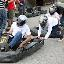

In [59]:
# imgs, labels = next(iter(dataloader))
data = TinyImageNetDataset(os.path.join('tiny_imagenet','val'))
img, label = data[0]
display(img)

In [60]:
# vit_model = vit_model.to(DEVICE)
# bit_model = bit_model.to(DEVICE)


# vit_pred_idx = classify(vit_model, processor, img)
# print("ViT prediction:", vit_model.config.id2label[vit_pred_idx])
# bit_pred_idx = classify(bit_model, feature_extractor, img)
# print("BiT prediction:", bit_model.config.id2label[bit_pred_idx])
# ground_truth = annotations.loc[0 , 'class']
# print("Ground truth:", ground_truth)

## Analysis

### Tiny ImageNet
- subset of ImageNet-1k
- contains 10,000 images and only 200 of the original 1000 classes

In [61]:
annotations.nunique(0)

filename    10000
class         200
dtype: int64

In [62]:
import time
data_dir = os.path.join('tiny_imagenet', 'val')
vit_dataloader = DataLoader(TinyImageNetDataset(data_dir, transform=processor), batch_size=64)
bit_dataloader = DataLoader(TinyImageNetDataset(data_dir, transform=feature_extractor), batch_size=64)

def get_accuracy_and_save(model, dataloader: DataLoader, device=torch.device('cpu'), filename=None):
    """
    Compute the accuracy of a model on a given DataLoader, 
    and optionally save the predictions and labels.
    
    Args:
        model: The model to evaluate.
        dataloader: DataLoader providing the dataset.
        device: The device on which to perform computations.
        filename: File to save predictions and labels (optional).
    
    Returns:
        Tuple containing accuracy and time taken for evaluation.
    """
    correct = 0
    all_preds = []
    all_labels = []
    total = len(dataloader.dataset)
    start = time.time()
    
    with torch.no_grad():
        for imgs, labels in dataloader:
            labels = labels.to(device)
            imgs = imgs.to(device)
            outputs = model(imgs)
            pred = outputs.logits.argmax(-1)
            correct += (pred == labels).sum().item()
            all_preds.append(pred.cpu().numpy())  # Move predictions to CPU
            all_labels.append(labels.cpu().numpy())
    
    accuracy = correct / total
    time_taken = time.time() - start
    # Optionally save predictions and labels
    if filename is not None:
        with open(filename, 'wb') as f:
            pickle.dump({'preds': np.concatenate(all_preds), 
                         'labels': np.concatenate(all_labels),
                         'accuracy': accuracy,
                        'time_taken': time_taken
                }, f)
        print(f"Saved results to {filename}")
    
    return accuracy, time_taken






In [ ]:
vit_accuracy, vit_time_taken = get_accuracy_and_save(vit_model, vit_dataloader, device=DEVICE, filename='vit_tiny_imagenet.pkl')
bit_accuracy, bit_time_taken = get_accuracy_and_save(bit_model, bit_dataloader, device=DEVICE, filename='bit_tiny_imagenet.pkl')
print(f"ViT Accuracy: {vit_accuracy*100:.2f}")
print(f"Time taken: {vit_time_taken:.2f}s")
print()
print(f"BiT Accuracy: {bit_accuracy*100:.2f}")
print(f"Time taken: {bit_time_taken:.2f}s")

In [10]:
def load_model_data(filename):
    with open(filename, 'rb') as f:
       data = pickle.load(f)
    return data['preds'], data['labels'], data['accuracy'], data['time_taken']


In [ ]:


# Example: Load confusion matrix data for ViT and BiT
vit_preds, vit_labels, _, _ = load_model_data('vit_tiny_imagenet.pkl')
bit_preds, bit_labels, _, _ = load_model_data('bit_tiny_imagenet.pkl')

# Compute confusion matrices for both models
cm_vit = confusion_matrix(vit_labels, vit_preds)
cm_bit = confusion_matrix(bit_labels, bit_preds)

# Get unique labels from the true labels



true_classes = np.unique(vit_labels)
pred_classes = np.unique(vit_preds)

print("Unique true classes:", true_classes[:10])
print("Unique predicted classes:", pred_classes[:10])



Unique true classes: [ 1 25 30 32 50 61 69 71 75 76]
Unique predicted classes: [ 0  1  5 10 14 21 23 25 26 27]


In [12]:
vit_preds = np.array(vit_preds)
vit_labels = np.array(vit_labels)
class_num = 30
# Identify correct predictions for class 1
correct_for_class = (vit_labels == class_num) & (vit_preds == class_num)
correct_count_class = correct_for_class.sum()  # Count of correct predictions

print(f"Correct predictions for class 1: {correct_count_class}")

Correct predictions for class 1: 14


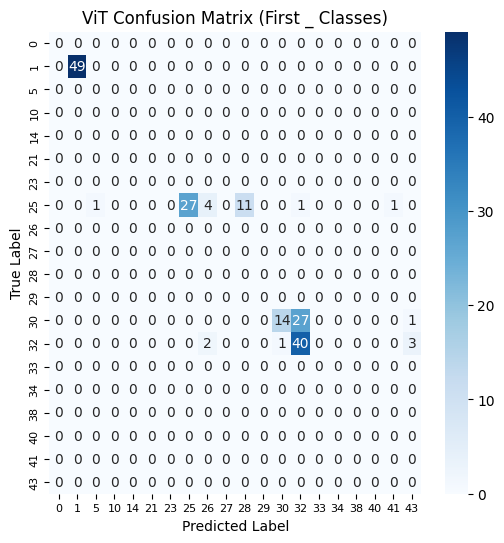

10000
[  1  25  30  32  50  61  69  71  75  76  79  99 105 107 109 113 114 115
 122 123 128 145 146 149 151 187 207 208 235 267 281 283 285 286 291 294
 301 308 309 311 313 314 315 319 323 325 329 338 341 345 347 349 353 354
 365 367 372 386 387 398 400 406 411 414 421 424 425 427 430 435 436 437
 438 440 445 447 448 457 458 462 463 466 467 470 471 474 480 485 488 492
 496 500 508 509 511 517 525 526 532 542 543 557 562 565 567 568 570 573
 576 604 605 612 614 619 621 625 627 635 645 652 655 675 677 678 682 683
 687 704 707 716 720 731 733 734 735 737 739 744 747 758 760 761 765 768
 774 779 781 786 801 806 808 811 815 817 821 826 837 839 842 845 849 850
 853 862 866 873 874 877 879 887 888 890 899 900 909 910 917 923 924 928
 929 932 935 938 945 947 950 951 954 957 962 963 964 967 970 972 973 975
 978 988]


In [41]:
num_classes_to_plot = 20



# Select the first 5 classes from the confusion matrix
cm_vit_filtered = cm_vit[:num_classes_to_plot, :num_classes_to_plot]

# Plot confusion matrix for ViT with reduced font size for labels
plt.figure(figsize=(6, 6))
sns.heatmap(cm_vit_filtered, fmt='d', annot=True, cmap='Blues', xticklabels=pred_classes[:num_classes_to_plot], yticklabels=pred_classes[:num_classes_to_plot])
plt.title('ViT Confusion Matrix (First _ Classes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()


print(len(vit_preds))
print(np.unique(vit_labels))

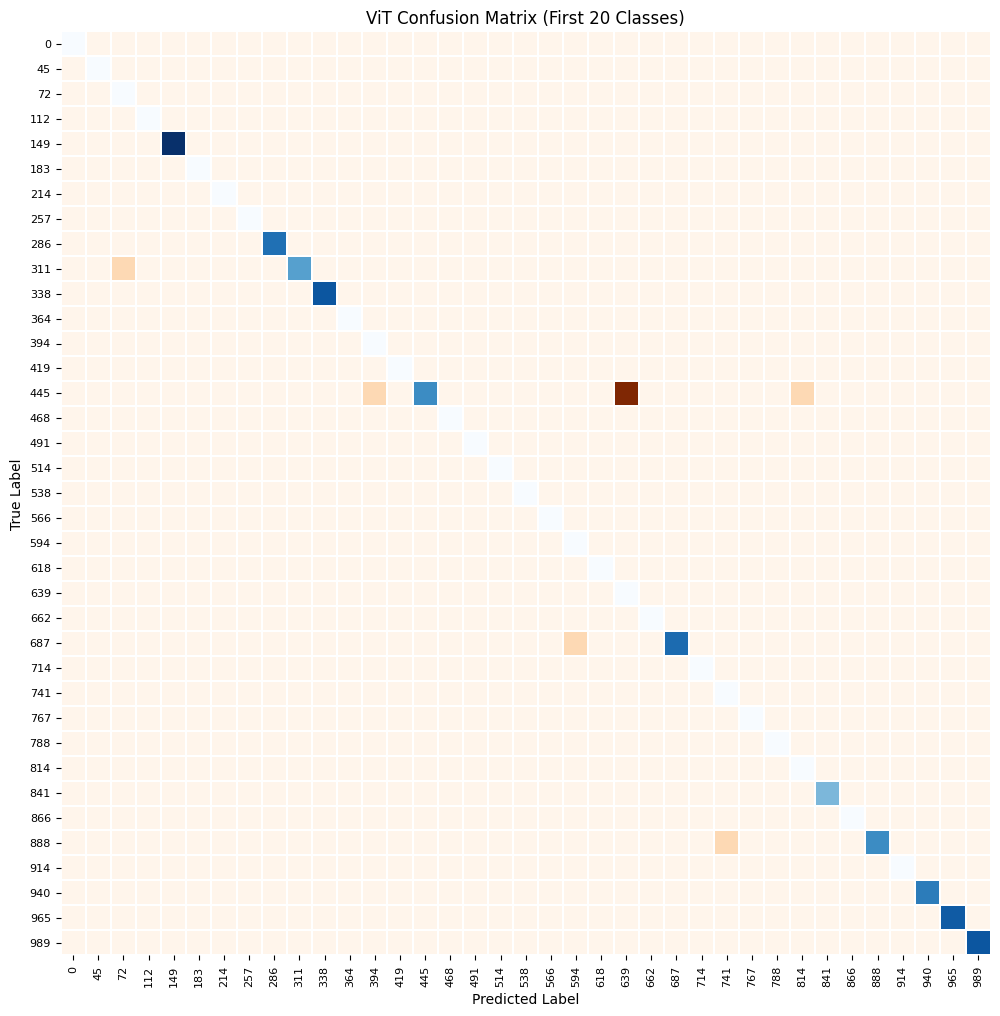

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Select the first 20 classes from the confusion matrix
num_classes_to_plot = 1000
skip = 20
cm_vit_filtered = cm_vit[:num_classes_to_plot:skip, :num_classes_to_plot:skip]

# Create a mask to distinguish between correct and incorrect predictions
mask_correct = np.eye(cm_vit_filtered.shape[0], dtype=bool)

# Create a custom colormap
cmap = sns.color_palette(["#d4f7d4", "#f7d4d4"])  # Green for correct, red for incorrect

# Plot the confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(
    cm_vit_filtered,
    annot=False,
    fmt="d",
    cmap="Blues",  # Use the custom colormap
    xticklabels=pred_classes[:num_classes_to_plot:skip],
    yticklabels=pred_classes[:num_classes_to_plot:skip],
    mask=~mask_correct,  # Highlight correct predictions
    cbar=False
)
sns.heatmap(
    cm_vit_filtered,
    annot=False,
    fmt="",
    cmap="Oranges",  # Highlight incorrect predictions
    xticklabels=pred_classes[:num_classes_to_plot:skip],
    yticklabels=pred_classes[:num_classes_to_plot:skip],
    mask=mask_correct,  # Ignore correct predictions
    cbar=False,
    linewidths=0.1,
)

# Labels and title
plt.title("ViT Confusion Matrix (First 20 Classes)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()


ViT Accuracy: 62.07%
Time taken: 47.49s

BiT Accuracy: 33.18%
Time taken: 113.03s



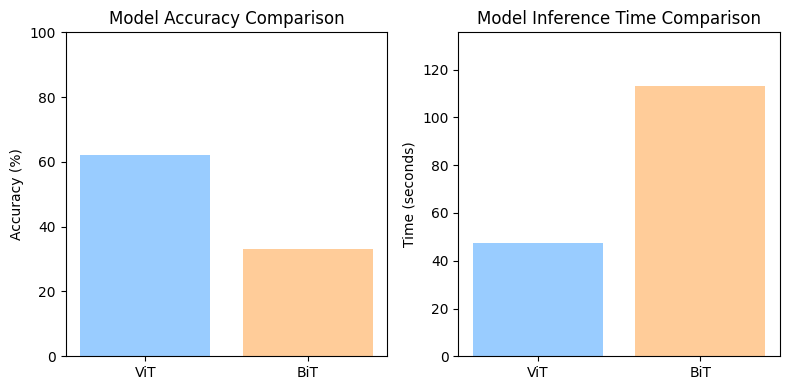

In [37]:

_, _, vit_accuracy, vit_time_taken = load_model_data('vit_tiny_imagenet.pkl')
_, _, bit_accuracy, bit_time_taken = load_model_data('bit_tiny_imagenet.pkl')
# Model names
models = ['ViT', 'BiT']

# Accuracy and time taken values
accuracies = [vit_accuracy * 100, bit_accuracy * 100]
times_taken = [vit_time_taken, bit_time_taken]


# Display results
for model, acc, time_taken in zip(['ViT', 'BiT'], [vit_accuracy * 100, bit_accuracy * 100], [vit_time_taken, bit_time_taken]):
    print(f"{model} Accuracy: {acc:.2f}%\nTime taken: {time_taken:.2f}s\n")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i, (data, title, ylabel, ylim) in enumerate(zip([[vit_accuracy * 100, bit_accuracy * 100], [vit_time_taken, bit_time_taken]],
                                                   ['Model Accuracy Comparison', 'Model Inference Time Comparison'],
                                                   ['Accuracy (%)', 'Time (seconds)'],
                                                   [100, max([vit_time_taken, bit_time_taken]) * 1.2])):
    ax[i].bar(['ViT', 'BiT'], data, color=['#99CCFF', '#FFCC99'])
    ax[i].set_title(title)
    ax[i].set_ylabel(ylabel)
    ax[i].set_ylim(0, ylim)

plt.tight_layout()
plt.show()


### ImageNet
- validation set: 50,000 images split among 1000 classes
- we use the validation set because the test set does not have publically-available ground-truth labels
    - but we still want to avoid using images that the models were trained on

In [38]:
data_dir = 'imagenet'
annotations_file = 'LOC_val_solution.csv'
vit_dataloader = DataLoader(ImageNetDataset(
    data_dir, annotations_file, transform=processor), batch_size=64)
bit_dataloader = DataLoader(ImageNetDataset(
    data_dir, annotations_file, transform=feature_extractor), batch_size=64)




In [24]:
vit_accuracy, vit_time_taken = get_accuracy_and_save(vit_model, vit_dataloader, device=DEVICE, filename='vit_imagenet.pkl')
bit_accuracy, bit_time_taken = get_accuracy_and_save(bit_model, bit_dataloader, device=DEVICE, filename='bit_imagenet.pkl')

print(f"ViT Accuracy: {vit_accuracy*100:.2f}")
print(f"Time taken: {vit_time_taken:.2f}s")
print()
print(f"BiT Accuracy: {bit_accuracy*100:.2f}")
print(f"Time taken: {bit_time_taken:.2f}s")

KeyboardInterrupt: 

In [ ]:
# Example: Load confusion matrix data for ViT and BiT
vit_preds, vit_labels, _, _ = load_model_data('vit_imagenet.pkl')
bit_preds, bit_labels, _, _ = load_model_data('bit_imagenet.pkl')

# Compute confusion matrices for both models
cm_vit = confusion_matrix(vit_labels, vit_preds)
cm_bit = confusion_matrix(bit_labels, bit_preds)

# Get unique labels from the true labels
unique_labels = np.unique(vit_labels)  # Using vit_labels, as an example
class_names = [f'class_{label}' for label in unique_labels]  # Replace with actual class names if available

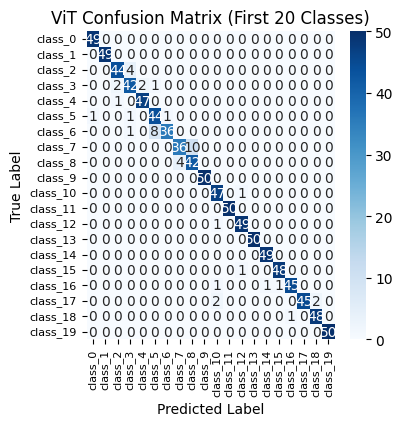

[784 587 241 512 278 677 232 920 396 773 647   8 851 410 435 140 894 294
 558 297]
[740 587 241 512 278 398 232 920 396 773 438   8 851 599 435 140 894 294
 683 297]


In [ ]:
num_classes_to_plot = 20

# Select the first 5 classes from the confusion matrix
cm_vit_filtered = cm_vit[:num_classes_to_plot, :num_classes_to_plot]

# Plot confusion matrix for ViT with reduced font size for labels
plt.figure(figsize=(4, 4))
sns.heatmap(cm_vit_filtered, annot=True, fmt='d', cmap='Blues', xticklabels=class_names[:num_classes_to_plot], yticklabels=class_names[:num_classes_to_plot])
plt.title('ViT Confusion Matrix (First 20 Classes)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()


print(vit_preds[:20])
print(vit_labels[:20])

ViT Accuracy: 80.32%
Time taken: 439.34s

BiT Accuracy: 80.36%
Time taken: 949.60s



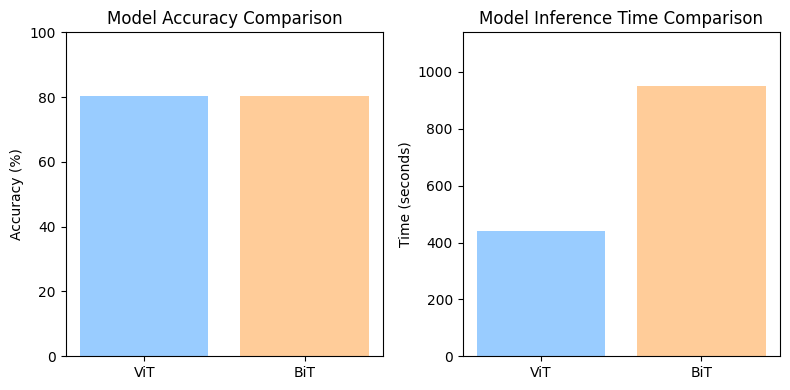

In [ ]:
_, _, vit_accuracy, vit_time_taken = load_model_data('vit_imagenet.pkl')
_, _, bit_accuracy, bit_time_taken = load_model_data('bit_imagenet.pkl')
# Model names
models = ['ViT', 'BiT']

# Accuracy and time taken values
accuracies = [vit_accuracy * 100, bit_accuracy * 100]
times_taken = [vit_time_taken, bit_time_taken]


# Display results
for model, acc, time in zip(['ViT', 'BiT'], [vit_accuracy * 100, bit_accuracy * 100], [vit_time_taken, bit_time_taken]):
    print(f"{model} Accuracy: {acc:.2f}%\nTime taken: {time:.2f}s\n")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i, (data, title, ylabel, ylim) in enumerate(zip([[vit_accuracy * 100, bit_accuracy * 100], [vit_time_taken, bit_time_taken]],
                                                   ['Model Accuracy Comparison', 'Model Inference Time Comparison'],
                                                   ['Accuracy (%)', 'Time (seconds)'],
                                                   [100, max([vit_time_taken, bit_time_taken]) * 1.2])):
    ax[i].bar(['ViT', 'BiT'], data, color=['#99CCFF', '#FFCC99'])
    ax[i].set_title(title)
    ax[i].set_ylabel(ylabel)
    ax[i].set_ylim(0, ylim)

plt.tight_layout()
plt.show()